In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd

import random

# Problema: Caxeiro viajante

_**Resumo:** Neste relatório é exposto o problema do caxeiro viajante, uma discussão e a implementação de um algoritmo genético (AH) para a sua solução. É utilizada a biblioteca `deap` para facilitar o processo de desenvolvimento._

## 1.1 Descrição

O problema do caxeiro viajante, também conhecido como _travelling salesman problem_ (TSP), consiste na procura de um caminho com a menor distância que percorra um conjunto de cidades especificadas, onde começando em uma cidade qualquer, percorra todas as outras cidades precisamente uma vez e regresse à cidade inicial (Nilsson, 1982).

 
## 2. Resolução do problema

### 2.1 Parâmetros gerais

São definidos a seguir os valores constantes para os parâmetros que são utilizados no algoritmo.

In [2]:
TOTAL_CIDADES = 100

TAMANHO_POPULACAO = 50
NUMERO_GERACOES = 1000

PERCENTUAL_MUTACAO = 0.1
PERCENTUAL_CRUZAMENTO = 0.8
PERCENTUAL_ELITISMO = 0.1

# Veja (2.5 Seleção) para mais detalhes
MINIMIZACAO = False

# deap_easimple
PROBABILIDADE_CRUZAMENTO = 0.5
PROBABILIDADE_MUTACAO = 0.2

### 2.2 Mapa

As cidades que devem ser visitadas é gerada aleatoriamente.

 * **Mapa**: Um _Mapa_ possui um catálogo contendo as $n$ cidades (onde $n=TOTAL\_CIDADES$). A implementação do – catálogo do – Mapa é uma lista (`list`) de cidades;
 * **Cidade**: Cada cidade possui dois atributos: posição no eixo $x$ e posição no eixo $y$. Uma _cidade_ é descrita no _Mapa_ como um item da lista. Uma cidade é implementado como uma `tuple` com dois valores, correspondendo respectivamente à $x$, $y$.

Os limites do mundo (local aonde encontram-se as cidades) são: $$(-500, -500), (500, -500), (-500, 500), (500, 500)$$
Ou seja, cada cidade é gerada com um $$ $x, y ∈ \mathbb{N}  \mid  x, y ⊂ [-500, 500]$$.

Podemos descrever uma cidade $c$ catalogada no Mapa através da indicação de sua posição no catálogo do Mapa. Para tal, utilizaremos a notação $$Mapa[i]$$, onde $$0 >= i > n-1$$, ou seja, $i$ corresponde ao índice da cidade $c$ no catálogo do Mapa ($c.indice = i$).

```python
>>> Mapa[5] # 6º elemento da lista
(2, -234) # (x, y)
```

In [3]:
posicao = lambda: int(random.random()*1000 - 500)

Mapa = map(lambda i: (posicao(), posicao()), range(TOTAL_CIDADES))
Mapa = list(Mapa)

print("6º Elemento da lista:", Mapa[5])

6º Elemento da lista: (-54, -456)


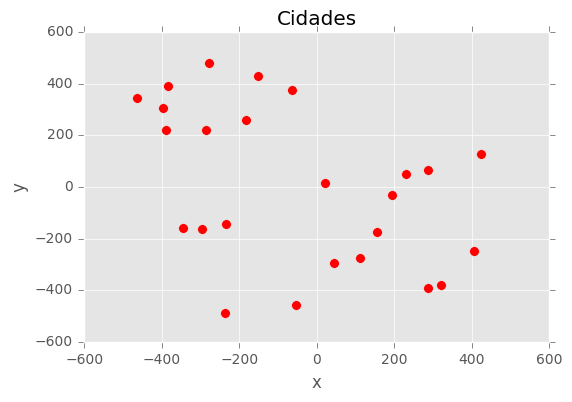

In [4]:
pd.DataFrame(data=Mapa, columns=['x', 'y']).plot(kind='scatter', x='x', y='y', s=50, color='red', title='Cidades');

### 2.3 Indivíduo e população

> "O Algoritmo Genético começa com um conjunto de $k = TAMANHO\_POPULACAO$ estados gerados aleatoriamente, chamado **população**. Cada estado, ou **indivíduo** é representado por uma cadeia sobre um alfabeto finito $A$."
> 
> — Adaptado de Inteligência Artificial – Uma abordagem moderna (2º Edição). Russel e Norvig

#### 2.3.1 Indivíduo

Nesta implementação de AG para o problema do Caxeiro Viajante, o alfabeto um indivídio $A$ é $$A = \{0, 1, ..., n-2, n-1\}, \mid n = TOTAL\_CIDADES$$, onde cada caractere do alfabeto possui uma correspondência com o índice de uma cidade no catálogo do mapa: o caractere $5$ do alfabeto corresponde à $Mapa[5]$, ou seja, a $6º$ cidade no catálogo do Mapa.

Resumindo: Um indivíduo é uma sequência de índices únicos.

#### 2.3.2 Percurso

Um indivíduo é composto por uma cadeia de caracteres do alfabeto $A$, contendo $n = TOTAL\_CIDADES$ caracteres únicos (sem repetição). Um indivíduo (estado) significa um percurso válido para o caxeiro viajante. Podemos descrever o **percurso** como uma travessia seguindo a sequência de cidades definidas pela cadeia de caracteres de um individuo. Como o caxeiro deve retornar ao local inicial no fim do trajeto, o percurso também conta o trajeto do último caractere da cadeia ao primeiro caractere.


```python
def percurso(individuo, Mapa):
    """
    Pseudo código para descrever um percurso definido por um indivíduo
    """
    for indice in range(TOTAL_CIDADES - 1): #[0..TOTAL_CIDADES-2]
        indice_cidade_1 = individuo[indice]
        indice_cidade_2 = individuo[indice+1]

        print(Mapa[indice_cidade_1], "->" Mapa[indice_cidade_2])
    
    # Indivíduo volta para a primeira cidade
    indice_cidade_1 = individuo[TOTAL_CIDADES-1]
    indice_cidade_2 = individuo[0]
    
    print(Mapa[indice_cidade_1], "->" Mapa[indice_cidade_1])
```

#### 2.3.3 Atributo fitness de um indivíduo

Em `deap` (a biblioteca utilizada), é necessário definir no indivíduo um atributo `fitness`, onde nele estará armazenado um objeto do tipo `base.Fitness`, que contém:
* O valor de fitness para um indivíduo (`individuo.fitness.values`);
* A informação se o fitness foi calculado para o indivíduo (`individuo.fitness.valid`);
* A descrição se queremos _minimizar_ o _maximizar_ o valor resultado da função de fitness para o indivíduo;

Para _minimizar_ o fitness, deve ser criado um `FitnessMinimo`, onde é definido um peso -1.0 (`weights=(-1.0,)`). Entretanto, como o método de seleção utilizado é o da **roleta**, é necessário utilizar um `FitnessMaximo` (com peso definido como 1.0 (`weights=(1.0,)`). Maiores detalhes podem ser obtidas na seção [2.5 Seleção](#2.5-Seleção). 

**Observação:** Observe que `weights` recebe um iterável de pesos. Observe também que é `individuo.fitness.values`, e não `individuo.fitness.value`. A biblioteca `deap` permite trabalhar com diversos atributos simultaneamente. Podemos então, por exemplo, buscar resultados que minimizem um primeiro atributo e maximizem um segundo atributo, como visitar todas as cidades por  um caminho que seja o mais curto e que a ordem das cidades seja mais próxima à alfabética (as primeiras cidades devem tender a começar com A e as últimas começar com Z).

In [5]:
from deap import base, creator

# Criando tipos
#  http://deap.readthedocs.io/en/master/tutorials/basic/part1.html

# "creator" cria uma classe
#  name = Nome da classe
#  base = classe que a classe criada herdará (FitnessMinimo extends base.Fitness)
#  weights=(-1.0,): Minimizar primeiro atributo
#  weights=(-1.0, 1.0): Minimiza primeiro atributo, maximiza segundo atributo

# Função de avaliação fitness
if MINIMIZACAO:
    creator.create(name="FitnessMinimo", base=base.Fitness, weights=(-1.0,))
    creator.create(name="Individuo", base=list, fitness=creator.FitnessMinimo, fitness_real=lambda self: self.fitness.values[0])
else:
    creator.create(name="FitnessMaximo", base=base.Fitness, weights=(1.0,))
    creator.create(name="Individuo", base=list, fitness=creator.FitnessMaximo, fitness_real=lambda self: 1/self.fitness.values[0])


#################
# Exemplo
#################

print("Exemplo de indivíduo")
individuo = creator.Individuo([0, 1, 2, 3, 4])
print(' - Indivíduo:', individuo)
print(' - Tipo do objeto:', type(individuo))
print(' - Cidades correspondentes:', list(map(lambda indice_cidade: Mapa[indice_cidade], individuo)))
print(' - Percurso:', end='')
for indice_cidade in individuo:
    print(Mapa[indice_cidade], '->', end=' ')
print(Mapa[individuo[0]])
print(' - Fitness definido?', individuo.fitness.valid)
print(' - Valores do fitness:', individuo.fitness.values)
print(' - Pesos dos fitness:', individuo.fitness.weights)
individuo.fitness.values = (5,)
print(' - Fitness definido?', individuo.fitness.valid)
print(' - Valores do fitness:', individuo.fitness.values)

Exemplo de indivíduo
 - Indivíduo: [0, 1, 2, 3, 4]
 - Tipo do objeto: <class 'deap.creator.Individuo'>
 - Cidades correspondentes: [(45, -295), (-64, 377), (-236, -489), (111, -274), (20, 14)]
 - Percurso:(45, -295) -> (-64, 377) -> (-236, -489) -> (111, -274) -> (20, 14) -> (45, -295)
 - Fitness definido? False
 - Valores do fitness: ()
 - Pesos dos fitness: (1.0,)
 - Fitness definido? True
 - Valores do fitness: (5.0,)


#### 2.3.4 População

A seguir definiremos como:

* **Gerar indivíduos aleatórios**:
É utilizado a função `random.sample(population, k)`:
> Return a k length list of unique elements chosen from the population sequence. Used for random sampling without replacement.
* **Gerar uma população de indivíduos aleatórios**

In [6]:
from deap import tools

TAMANHO_INDIVIDUO = TOTAL_CIDADES

toolbox = base.Toolbox()

# Attribute generator

# Gerar indivíduos 
toolbox.register("indices", random.sample, range(TAMANHO_INDIVIDUO), TAMANHO_INDIVIDUO)
#  toolbox.individuo() consegue gerar deap.creator.Individuo através do generator=toolbox.indices
#  container = Tipo dos individuos a serem gerados
toolbox.register("individuo", tools.initIterate, container=creator.Individuo, generator=toolbox.indices)

# Gerar uma população de indivíduos aleatórios
toolbox.register("populacao", tools.initRepeat, list, toolbox.individuo)


#################
# Exemplo
#################
individuo = toolbox.individuo()
populacao = toolbox.populacao(n=3)

print("Individuo é do tipo %s e contém %d elementos (genes)\n%s" % (type(individuo), len(individuo), individuo))
print()
print("Populacao é do tipo %s e contém %d indivíduos" % (type(populacao), len(populacao)))
for individuo in populacao:
    print(" -", individuo)

Individuo é do tipo <class 'deap.creator.Individuo'> e contém 25 elementos (genes)
[17, 9, 13, 22, 11, 10, 6, 15, 2, 5, 24, 19, 4, 1, 16, 23, 12, 0, 21, 18, 14, 20, 7, 8, 3]

Populacao é do tipo <class 'list'> e contém 3 indivíduos
 - [23, 7, 22, 0, 24, 4, 16, 8, 6, 11, 12, 17, 9, 5, 2, 3, 20, 14, 21, 18, 10, 19, 15, 1, 13]
 - [13, 2, 21, 4, 11, 19, 7, 15, 6, 16, 0, 9, 18, 23, 5, 3, 20, 12, 1, 22, 24, 8, 10, 14, 17]
 - [21, 20, 24, 11, 3, 19, 17, 9, 1, 8, 18, 4, 0, 12, 10, 2, 16, 6, 7, 5, 14, 22, 15, 23, 13]


### 2.4 Função de avaliação ou de _fitness_

A função fitness, definida também como função de avaliação, calcula para um indivíduo passado a distância euclidiana de um percurso.
Ou seja, a distância euclidiana de percorer da primeira cidade de um percurso para a segunda, mais a distância euclidiana de percorrer da segunda cidade para a terceira, assim sucessivamente para todas as cidades do percurso.

A distância euclidiana por entre dois pontos ${\displaystyle P=(p_{x},p_{y})}$ e ${\displaystyle Q=(q_{x},q_{y})}$ é dada como $${\displaystyle {\sqrt {(p_{x}-q_{x})^{2}+(p_{y}-q_{y})^{2}}}.}$$

In [7]:
import math

def distancia_euclidiana(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def funcao_de_fitness(individuo):
    distancia = 0
    
    for gene1, gene2 in zip(individuo[0:-1], individuo[1:]):
        gene1 = Mapa[gene1]
        gene2 = Mapa[gene2]
        
        distancia += distancia_euclidiana(gene1, gene2)
    
    # Voltar para o caminho inicial
    gene1 = Mapa[0]
    gene2 = Mapa[-1]
    distancia += distancia_euclidiana(gene1, gene2)
    
    return distancia,

def funcao_de_fitness_maximizacao(individuo):
    return 1/funcao_de_fitness(individuo)[0],

# Registrando a função de fitness
if MINIMIZACAO:
    toolbox.register("evaluate", funcao_de_fitness)
else:
    toolbox.register("evaluate", funcao_de_fitness_maximizacao)

################
# Exemplo
################
individuo = creator.Individuo(range(5))
print("Função avaliadora para o indivíduo", individuo)
print(" - Valor para minimização: ", funcao_de_fitness(individuo))
print(" - Valor para maximização: ", funcao_de_fitness_maximizacao(individuo))

Função avaliadora para o indivíduo [0, 1, 2, 3, 4]
 - Valor para minimização:  (2640.1721102854426,)
 - Valor para maximização:  (0.0003787631859696771,)


### 2.5 Seleção

É necessária uma forma para escolher os indivídos que sofrerão mutação e os e que cruzarão para que as gerações convirjam para a solução. Foi escolhido o método da roleta, cuja sua implementação no deap é:

`deap.tools.selRoulette(individuals, k, fit_attr='fitness')`
> Select k individuals from the input individuals using k spins of a roulette. The selection is made by looking only at the first objective of each individual. The list returned contains references to the input individuals.

A [documentação](http://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selRoulette) informa que não é possível utilizar o método da roleta para minimizações.
> <div class="alert alert-warning">
Warning The roulette selection by definition cannot be used for minimization or when the fitness can be smaller or equal to 0.
</div>

Desta forma, a função de fitness foi adaptada para computar o inverso da distância entre as cidades ($1 / distancia\ do\ percurso$).

C
MINIMIZACAO

Foi utilizado `tools.selTournament(individuals, k, tournsize, fit_attr='fitness')`
> Select k individuals from the input individuals using k tournaments of tournsize individuals. The list returned contains references to the input individuals.



In [8]:
#toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("select", tools.selRoulette)

### 2.6 Mutação

Foi utilizado para a mutação `tools.mutShuffleIndexes(individual, indpb)`, que gera um mutante a partir de um indivíduo fazendo um _shuffle_ (alterando a ordem) nos atributos do indivíduo. Ou seja, alterando a ordem que o caxeiro visita as cidades.

É necessário especificar também a probabilidade de realizar um _shuffle_ em cada elemento (atributo `indpb`). A probabilidade escolhida foi $0.05$.

In [9]:
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

################
# Exemplo
################
individuo = creator.Individuo(range(10))
probabilidade = 0.20  # Probabilidade maior pra demonstrar o shuffle

print('Exemplo com probabilidade', probabilidade)
print(' - Individuo:', individuo)
print(' - Probabilidade:', probabilidade)
print(' - Resultado:', tools.mutShuffleIndexes(individuo, indpb=probabilidade))

Exemplo com probabilidade 0.2
 - Individuo: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 - Probabilidade: 0.2
 - Resultado: ([0, 1, 2, 6, 4, 5, 3, 7, 8, 9],)


### 2.7 Cruzamento

Foi utilizado o cruzamento `tools.cxPartialyMatched(ind1, ind2)`

> Executes a partially matched crossover (PMX) on the input individuals. The two individuals are modified in place. This crossover expects sequence individuals of indices, the result for any other type of individuals is unpredictable.



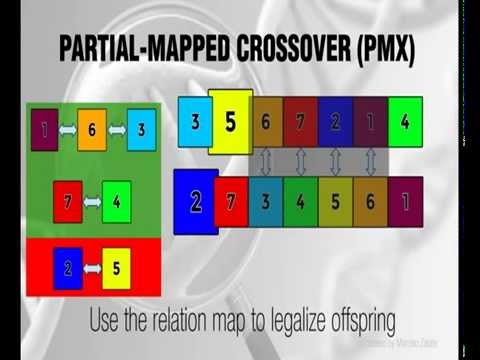

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("c2ft8AG8JKE")

In [11]:
toolbox.register("mate", tools.cxPartialyMatched)

################
# Exemplo
################
individuo_1 = creator.Individuo(range(10))
individuo_2 = creator.Individuo(reversed(range(10)))

print("PMX")
print(" - Indivíduo 1", individuo_1)
print(" - Indivíduo 2", individuo_2)
print(" - Cruzamento PMX")
print("  ", tools.cxPartialyMatched(individuo_1, individuo_2))

PMX
 - Indivíduo 1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 - Indivíduo 2 [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
 - Cruzamento PMX
   ([9, 8, 7, 3, 4, 5, 6, 2, 1, 0], [0, 1, 2, 6, 5, 4, 3, 7, 8, 9])


## 3. Execução

São mostrados dois algoritmos para a execução: um que realiza os cálculos manualmente e outro que faz a evolução da população pela biblioteca $deap$.

### 3.1 Método 1 - Manual

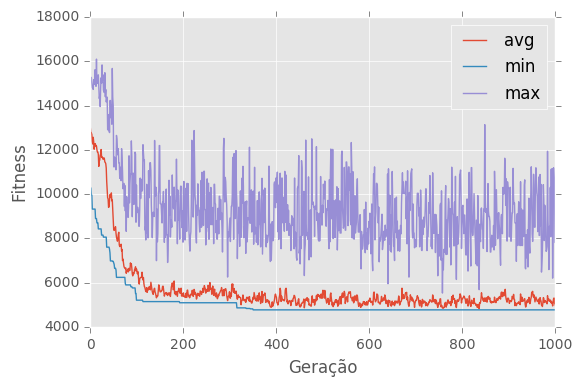

In [13]:
def main():
    populacao = toolbox.populacao(n=TAMANHO_POPULACAO)
    
    # Aplicar função de fitness para cada indivíduo
    calcular_fitness(populacao, toolbox.evaluate)
    valores = pd.Series(map(lambda individuo: individuo.fitness.values[0], populacao))
    
    historico = gerar_historico(populacao)

    for geracao in range(NUMERO_GERACOES):
        populacao = clonar(populacao)
        
        populacao_elitismo = selecionar_individuos_elitismo(populacao, PERCENTUAL_ELITISMO)
        populacao_cruzamento = aplicar_cruzamento(populacao, PERCENTUAL_CRUZAMENTO)
        populacao_mutacao = aplicar_mutacao(populacao, PERCENTUAL_MUTACAO)
        
        calcular_fitness(populacao_cruzamento, toolbox.evaluate)
        calcular_fitness(populacao_mutacao, toolbox.evaluate)
        
        populacao[:] = populacao_elitismo + populacao_cruzamento + populacao_mutacao
        historico = gerar_historico(populacao, historico)

    return populacao, historico

def clonar(populacao):
    """
    Clone uma população para evitar efeitos colaterais indesejados
    """
    return list(map(toolbox.clone, populacao))
    
def gerar_historico(populacao, dataframe=None):
    if dataframe is None:
        dataframe = pd.DataFrame(columns=['avg', 'min', 'max'])
    
    valores = pd.Series(map(lambda individuo: individuo.fitness_real(), populacao))
        
    data = {
        'min': valores.min(),
        'max': valores.max(),
        'avg': valores.mean(),
    }

    return dataframe.append(data, ignore_index=True)
    
def selecionar_individuos_elitismo(populacao, percentual):
    total_elitismo = int(len(populacao) * percentual)
    criaturas = sorted(populacao, key=lambda individuo: individuo.fitness.values[0], reverse=not MINIMIZACAO)

    return clonar(criaturas[0:total_elitismo])

def aplicar_cruzamento(populacao, percentual):
    populacao = selecionar_individuos_cruzamento(populacao, percentual)
    populacao = clonar(populacao)
    pares = populacao[::2]
    impares = populacao[1::2]

    for filho1, filho2 in zip(pares, impares):
        toolbox.mate(filho1, filho2)
        del filho1.fitness.values
        del filho2.fitness.values

    return populacao

def selecionar_individuos_cruzamento(populacao, percentual):
    total_cruzamento = int(len(populacao) * percentual)
    return toolbox.select(populacao, total_cruzamento)

def aplicar_mutacao(populacao, percentual):
    total_mutacao = int(len(populacao) * percentual)
    populacao = toolbox.select(populacao, total_mutacao)
    populacao = clonar(populacao)
    
    for mutant in populacao:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    return populacao

def calcular_fitness(populacao, funcao_avaliacao):
    """
    Aplica função de fitness para cada indivíduo
    de uma população
    """
    resultados_fitness = map(funcao_avaliacao, populacao)
    for individuo, fitness in zip(populacao, resultados_fitness):
        individuo.fitness.values = fitness

populacao_resultado, historico = main()


ax = historico.plot()

ax.set_xlabel("Geração")
ax.set_ylabel("Fitness")

Melhor indivíduo
 - Fitness: 4771.408115957235
 - Valor
 [6, 11, 18, 1, 19, 23, 21, 9, 17, 14, 4, 13, 3, 0, 5, 10, 12, 8, 20, 15, 7, 16, 22, 24, 2]


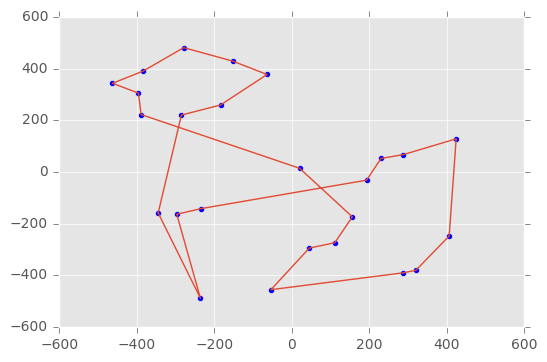

In [14]:
import numpy as np

def plot_caminho(melhor_individuo):
    x, y = np.asarray(Mapa).T

    caminho = melhor_individuo + melhor_individuo[0:1]
    melhor_caminho_x, melhor_caminho_y = np.asarray([Mapa[indice_cidade] for indice_cidade in caminho]).T

    plt.scatter(x, y)
    plt.plot(melhor_caminho_x, melhor_caminho_y)
    plt.show()

melhor_individuo = sorted(populacao_resultado, key=lambda individuo: individuo.fitness.values[0], reverse=not MINIMIZACAO)[0]

print("Melhor indivíduo")
print(" - Fitness:", melhor_individuo.fitness_real())
print(" - Valor\n", melhor_individuo)

plot_caminho(melhor_individuo)

### 3.2 Método 2 - Utilizando `deap`

A biblioteca `deap` possui [algumas implementações](http://deap.readthedocs.io/en/master/api/algo.html) de algoritmos evolutivos comumente utilizados.

Dentre eles, temos:

 * [`deap.algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen[, stats, halloffame, verbose])`](http://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms.eaSimple)
> This algorithm reproduce the simplest evolutionary algorithm as presented in chapter 7 of [Back2000].
>
> [Back2000]	Back, Fogel and Michalewicz, “Evolutionary Computation 1 : Basic Algorithms and Operators”, 2000.
 * [`deap.algorithms.eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen[, stats, halloffame, verbose])`](http://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms.eaMuPlusLambda)
> This is the $(\mu + \lambda)$ evolutionary algorithm.
 * [`deap.algorithms.eaMuCommaLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen[, stats, halloffame, verbose])`](http://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms.eaMuCommaLambda)
> This is the $(\mu~,~\lambda)$ evolutionary algorithm.

O exemplo a seguir demonstra a utilização do **`deap.algorithms.eaSimple`** para o problema do caxeiro viajante com a **seleção por torneio** com três turnos.

`tools.selTournament(individuals, k, tournsize, fit_attr='fitness')`
> Select k individuals from the input individuals using k tournaments of tournsize individuals. The list returned contains references to the input individuals.


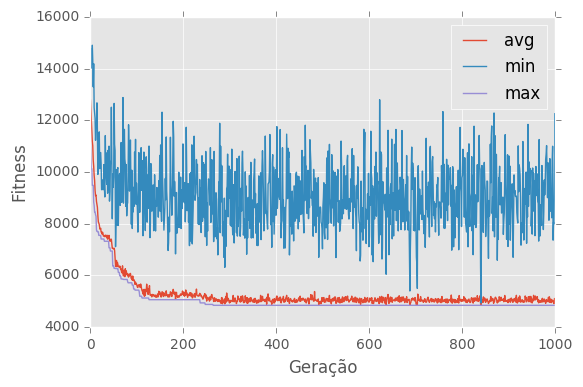

In [18]:
from deap import algorithms
toolbox.register("population", tools.initRepeat, list, toolbox.individuo)
toolbox.register("select", tools.selTournament, tournsize=3)

def deap_easimple():
    import numpy
    
    pop = toolbox.population(n=TAMANHO_POPULACAO)
    hof = tools.HallOfFame(1)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    populacao, logbook = algorithms.eaSimple(
        pop,
        toolbox,
        cxpb=PROBABILIDADE_CRUZAMENTO,
        mutpb=PROBABILIDADE_MUTACAO,
        ngen=NUMERO_GERACOES,
        stats=stats,
        halloffame=hof,
        verbose=False
    )
    
    return algorithms, logbook, hof

populacao, log, hall_of_fame = deap_easimple()

gen, avg, minimo, maximo = log.select("gen", "avg", "min", "max")

if not MINIMIZACAO:
    avg = 1/np.asarray(avg)
    minimo = 1/np.asarray(minimo)
    maximo = 1/np.asarray(maximo)

plt.plot(gen, avg, label="avg")
plt.plot(gen, minimo, label="min")
plt.plot(gen, maximo, label="max")

plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.legend(loc="best")

plt.show()

Melhor indivíduo
 - Fitness: 4837.028555938443
 - Valor
 [11, 18, 1, 20, 15, 7, 16, 22, 24, 6, 2, 5, 0, 10, 12, 8, 3, 13, 4, 19, 23, 21, 9, 17, 14]


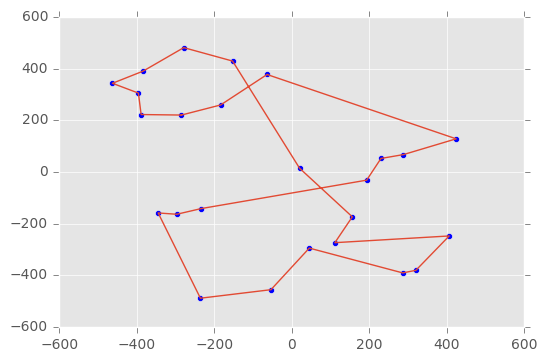

In [19]:
print("Melhor indivíduo")
print(" - Fitness:", hall_of_fame[0].fitness_real())
print(" - Valor\n", hall_of_fame[0])

plot_caminho(hall_of_fame[0])

## 4. Referências

Solução baseada em: 
 * Biblioteca `deap` - http://deap.readthedocs.io/en/master/overview.html
 * Exemplo do TSP em `deap` - https://github.com/DEAP/deap/blob/master/examples/ga/tsp.py
 * Exemplo do OneMax em `deap` - https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb
 * http://conteudo.icmc.usp.br/pessoas/andre/research/genetic/
 * NILSSON, Nils J. – Principals of artificial intelligence. New York: edição de Birkhauser, 1982. ISBN 978-3-540-11340-9
